# Face Recognition (Eigen Faces)

<img src="plot_face_recognition.png" height="60%"/>

"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""

# IMPORT STATEMENT

In [1]:
from time import time
import logging
import itertools
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

E:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Downloading Data

In [3]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


In [5]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [6]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


## Get Insight of Data

In [7]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Splitting Data into Training and Testing Set

In [8]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 90


In [10]:
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 90 eigenfaces from 966 faces


E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.233s


In [11]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [12]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))
print("Varianca:",pca.explained_variance_ratio_)

Projecting the input data on the eigenfaces orthonormal basis
done in 0.071s
Varianca: [ 0.19346547  0.15116844  0.07083685  0.05951802  0.05157505  0.02887152
  0.02514479  0.02176467  0.02019382  0.01902123  0.01682209  0.01580599
  0.01223361  0.01087932  0.01064447  0.00979646  0.00892387  0.00854827
  0.00835699  0.00722624  0.00696547  0.00653827  0.00639544  0.00561289
  0.00531071  0.00520093  0.00507404  0.00484116  0.00443536  0.0041775
  0.00393505  0.00381467  0.00355901  0.00350913  0.00334334  0.00329636
  0.0031437   0.00296013  0.00289447  0.00284339  0.0027937   0.00267068
  0.00259358  0.00257989  0.0023997   0.00238443  0.00234587  0.00221734
  0.00216392  0.00215351  0.00208148  0.00203191  0.00199543  0.00195533
  0.0019132   0.00186072  0.00178852  0.00175125  0.0017257   0.00171256
  0.00162309  0.00158959  0.00152711  0.00150351  0.0014668   0.00142127
  0.00141051  0.00137703  0.001357    0.00133019  0.00128608  0.00126705
  0.00123063  0.0012243   0.00117222  

In [13]:
###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 18.189s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [14]:
# Quantitative evaluation of the model quality on the test set

print( "Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting the people names on the testing set
done in 0.070s


## Function to Draw Confusion Matrix

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Printing Classification Report and Confusion Matrix

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.62      0.76        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.84      0.97      0.90       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.90      0.75      0.82        36

      avg / total       0.87      0.86      0.85       322

Confusion matrix, without normalization
[[  8   1   2   2   0   0   0]
 [  0  54   0   6   0   0   0]
 [  0   2  17   8   0   0   0]
 [  0   3   0 142   0   0   1]
 [  0   0   0   4  20   0   1]
 [  0   3   0   1   2   8   1]
 [  0   2   0   6   1   0  27]]


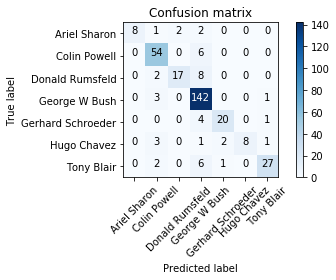

In [16]:
print( classification_report(y_test, y_pred, target_names=target_names))
cnf_matrix=confusion_matrix(y_test, y_pred, labels=range(n_classes))
plot_confusion_matrix(cnf_matrix,target_names)


## Let's Check the f1 score

In [17]:
from sklearn.metrics import f1_score
print("f1 score:",f1_score(y_test, y_pred,labels=range(n_classes),average='macro'))

f1 score: 0.801969974815


# Plotting Image Gallery

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

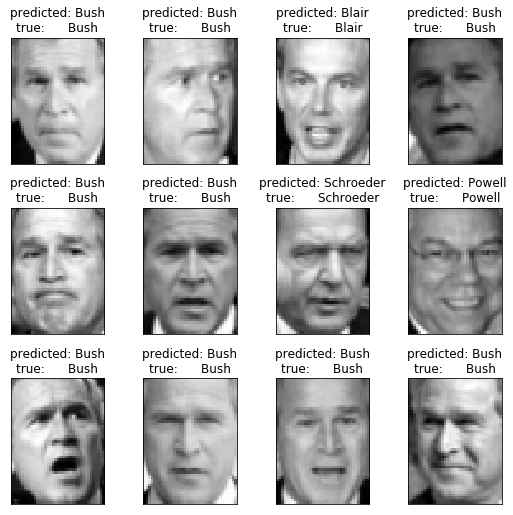

In [19]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

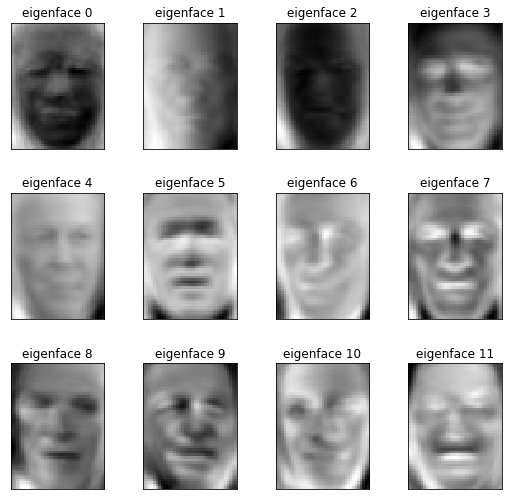

In [20]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


# Thank You